In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-05-23 20:52:37.854371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))    
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


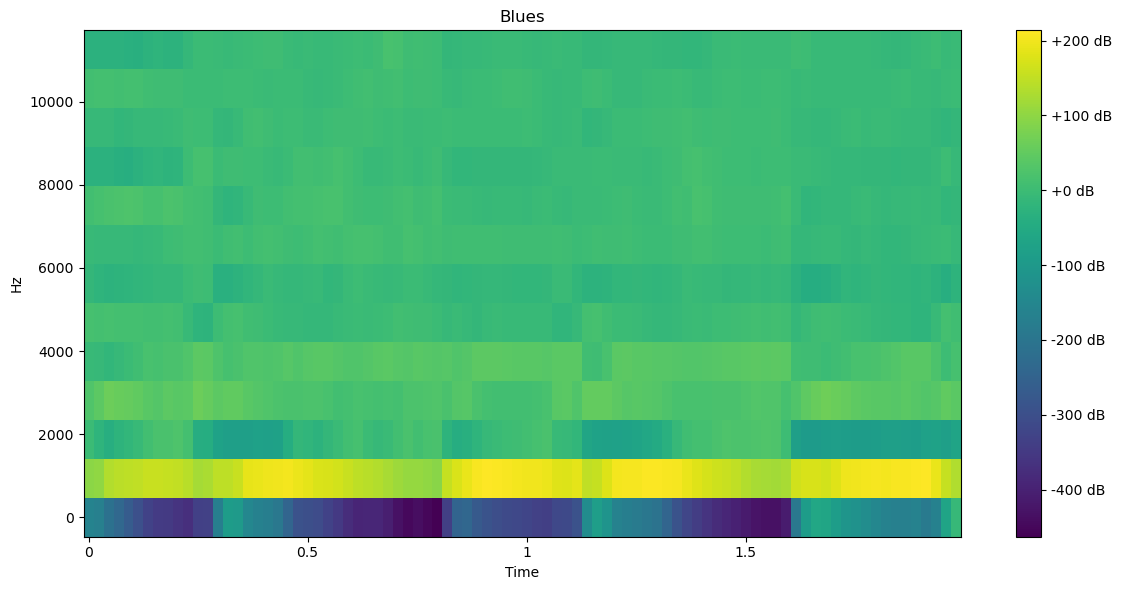

In [3]:
path_prefix = "/home/efectn/python-music-classification"
feature_path = os.path.join(path_prefix, "dataset/features_2.0_sec.json")
with open(feature_path, "r") as fp:
    data = json.load(fp)
    
idx = 100
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");


In [5]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name


X training data shape: (8390, 88, 13), y training data shape: (8390,)
X validation data shape: (2098, 88, 13), y validation data shape: (2098,)


In [7]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
print("a", X_train_cnn.shape)
print("a", X_test_cnn.shape)
print("a", input_shape)

model_cnn1 = Sequential()

model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

model_cnn1.add(Dense(10, activation='softmax')) 

model_cnn1.summary()


a (8390, 88, 13, 1)
a (4496, 88, 13, 1)
a (88, 13, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 86, 11, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 6, 32)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 41, 4, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 2, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 1, 64)         16448     
                                                                 


In [ ]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

In [ ]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

plot_history(hist_cnn1)

In [7]:
model_cnn2 = Sequential()

model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.2))

model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

model_cnn2.add(Dense(10, activation='softmax'))

model_cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 86, 11, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 86, 11, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 43, 6, 32)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 41, 4, 64)         18496     
                                                                 
 batch_normalization_1 (Batc  (None, 41, 4, 64)       

In [8]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
132/132 [==============================] - 7s 43ms/step - loss: 2.9232 - acc: 0.1905 - val_loss: 2.0460 - val_acc: 0.2669
Epoch 2/250
132/132 [==============================] - 4s 29ms/step - loss: 2.1650 - acc: 0.2999 - val_loss: 2.0024 - val_acc: 0.3065
Epoch 3/250
132/132 [==============================] - 3s 24ms/step - loss: 1.9235 - acc: 0.3538 - val_loss: 1.8997 - val_acc: 0.3637
Epoch 4/250
132/132 [==============================] - 3s 24ms/step - loss: 1.7499 - acc: 0.3926 - val_loss: 1.9111 - val_acc: 0.3880
Epoch 5/250
132/132 [==============================] - 3s 25ms/step - loss: 1.6365 - acc: 0.4221 - val_loss: 1.7977 - val_acc: 0.4199
Epoch 6/250
132/132 [==============================] - 3s 25ms/step - loss: 1.5522 - acc: 0.4454 - val_loss: 1.8139 - val_acc: 0.4399
Epoch 7/250
132/132 [==============================] - 3s 24ms/step - loss: 1.4889 - acc: 0.4696 - val_loss: 1.7970 - val_acc: 0.4581
Epoch 8/250
132/132 [==============================] - 3s 25ms

141/141 [==============================] - 1s 7ms/step - loss: 0.6217 - acc: 0.8256
Test Loss: 0.6216985583305359
Test Accuracy: 0.8256227970123291


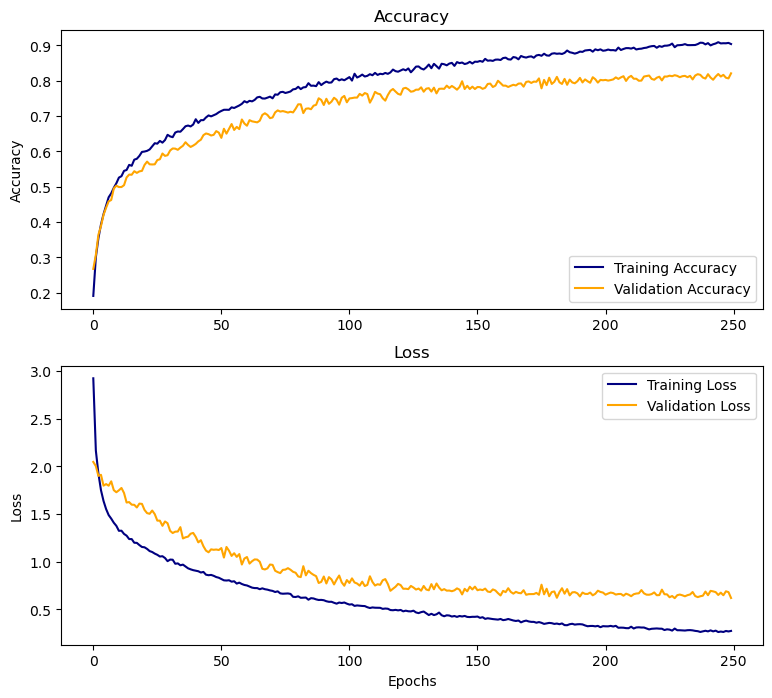

In [9]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

plot_history(hist_cnn2)

In [11]:
preds_num, preds_name = make_prediction(model_cnn2, X_test)

1/1 [==============================] - 0s 14ms/step


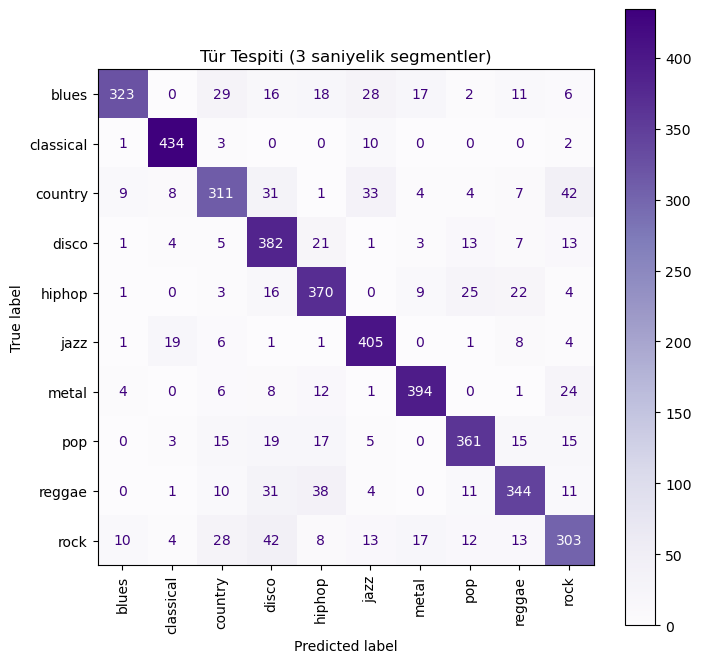

In [12]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');


In [10]:
model_cnn2.save(os.path.join(path_prefix, "models/model_cnn.h5"))